## Análise Exploratória de Dados e Pré-processamento

Bruno E A Hayek - R.A: 10389776

Xuan Zhu - R.A: 10401714


In [118]:
import pandas as pd
import talib
import os
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [119]:
nltk.download('stopwords')

# Dataset das ações 100 maiores ações da Nasdaq, separando cada coluna com o separado \t
nasdaq_raw = pd.read_csv('datasets/NASDAQ_100_Data_From_2010.csv',sep='\t',parse_dates = ['Date']) 

# Dataset das headlines das notícias do twitter
twitter_raw = pd.read_csv('datasets/twitter_financial_news/sent_train.csv') 

len(nasdaq_raw)
len(twitter_raw)

nasdaq_raw

[nltk_data] Downloading package stopwords to /home/bruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Date,Open,High,Low,Close,Adj_Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.562591,493729600,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.457407,477131200,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,AAPL
...,...,...,...,...,...,...,...,...
271675,2021-09-03,295.325012,301.804993,292.029999,298.290009,298.290009,6127900,ZM
271676,2021-09-07,298.295013,300.980011,294.799988,299.959991,299.959991,4251900,ZM
271677,2021-09-08,299.549988,299.959991,290.529999,293.600006,293.600006,3934400,ZM
271678,2021-09-09,292.160004,297.570007,291.130005,295.859985,295.859985,3350100,ZM


## Pré-processamento dos dados

In [120]:
#Deletando linhas com valores nulos e repetidos 

nasdaq_raw = nasdaq_raw.drop_duplicates()
nasdaq_raw = nasdaq_raw.dropna()

twitter_raw = twitter_raw.drop_duplicates()
twitter_raw = twitter_raw.dropna()

twitter_raw

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


Pré-processamento do dataset dos títulos de notícia do twitter

In [121]:
twitter_dados = twitter_raw.copy()

twitter_dados["text"] = twitter_dados["text"].str.lower()

#Removendo URLs
url_pattern = re.compile(r'https?://\S+|www\.\S+')
twitter_dados["text"] = twitter_dados["text"].str.replace(url_pattern, '', regex=True)

#Removendo hashtags e mencoes
twitter_dados["text"] = twitter_dados["text"].str.replace(r'#', '', regex=True)
twitter_dados["text"] = twitter_dados["text"].str.replace(r'@\w+', '', regex=True)

#Removendo caracteres especiais
twitter_dados["text"] = twitter_dados["text"].str.replace(r'[^\w\s]', '', regex=True)

#Removendo espaco em branco extra 
twitter_dados["text"] = twitter_dados["text"].str.replace(r'\s+', ' ', regex=True).str.strip()

#Removendo palavras vazias (stop words)
stop_words = set(stopwords.words('english'))
def remover_stopwords(texto):
    tokens = texto.split()
    return " ".join([word for word in tokens if word not in stop_words])

twitter_dados["text"] = twitter_dados["text"].apply(remover_stopwords)


#Tokenizer do FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

def tokenize_texto(texto):
    return tokenizer(texto, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

#Criando uma coluna do texto tokenizado
twitter_dados["tokenized"] = twitter_dados["text"].apply(tokenize_texto)

sentimentos_labels = {
    0: "Bearish", 
    1: "Bullish", 
    2: "Neutral"
}  

twitter_dados['Sentimentos'] = twitter_dados['label'].map(sentimentos_labels)


twitter_dados



"""
Referências:

https://huggingface.co/ProsusAI/finbert
https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing#Removal-of-Punctuations

"""



'\nReferências:\n\nhttps://huggingface.co/ProsusAI/finbert\nhttps://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing#Removal-of-Punctuations\n\n'

Pré-processamento do dataset das ações das 100 maiores empresas da Nasdaq

In [122]:
nasdaq_dados = nasdaq_raw.copy()

#Simple Moving Average (SMA) de 15 dias
nasdaq_dados['SMA_15'] = talib.SMA(nasdaq_dados['Adj_Close'], timeperiod=15)

#RSI
nasdaq_dados['RSI'] = talib.RSI(nasdaq_dados['Adj_Close'],timeperiod=14)

#Porcentagem do retorno diário, comparando a linha n com a n-1
nasdaq_dados['Retorno'] = nasdaq_dados['Adj_Close'].pct_change()

nasdaq_dados['Flutuacao_Diaria'] = nasdaq_dados['High'] - nasdaq_dados['Low']

nasdaq_dados.dropna(inplace=True)

nasdaq_dados['Date'] = pd.to_datetime(nasdaq_dados['Date'])
nasdaq_dados['Year'] = nasdaq_dados['Date'].dt.year

nasdaq_dados

"""
Referências:
https://ta-lib.github.io/ta-lib-python/doc_index.html
https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html

"""

'\nReferências:\nhttps://ta-lib.github.io/ta-lib-python/doc_index.html\nhttps://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html\n\n'

In [123]:
#Normalização dos dados

features = ['Adj_Close', 'SMA_15', 'RSI', 'Retorno','Flutuacao_Diaria'] #features para a normalizacao

scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(nasdaq_dados[features])

scaled_feature_nomes = [f'{col}_scaled' for col in features]

nasdaq_scaled = pd.DataFrame(scaled_features, columns=scaled_feature_nomes, index=nasdaq_dados.index)

nasdaq_dados[scaled_feature_nomes] = nasdaq_scaled

nasdaq_dados


"""
Referências:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

"""

'\nReferências:\nhttps://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html\n\n'

## Análise Exploratória de Dados

Gráfico com valores do Fechamento Ajustado e valores normalizados do Fechamento Ajustado

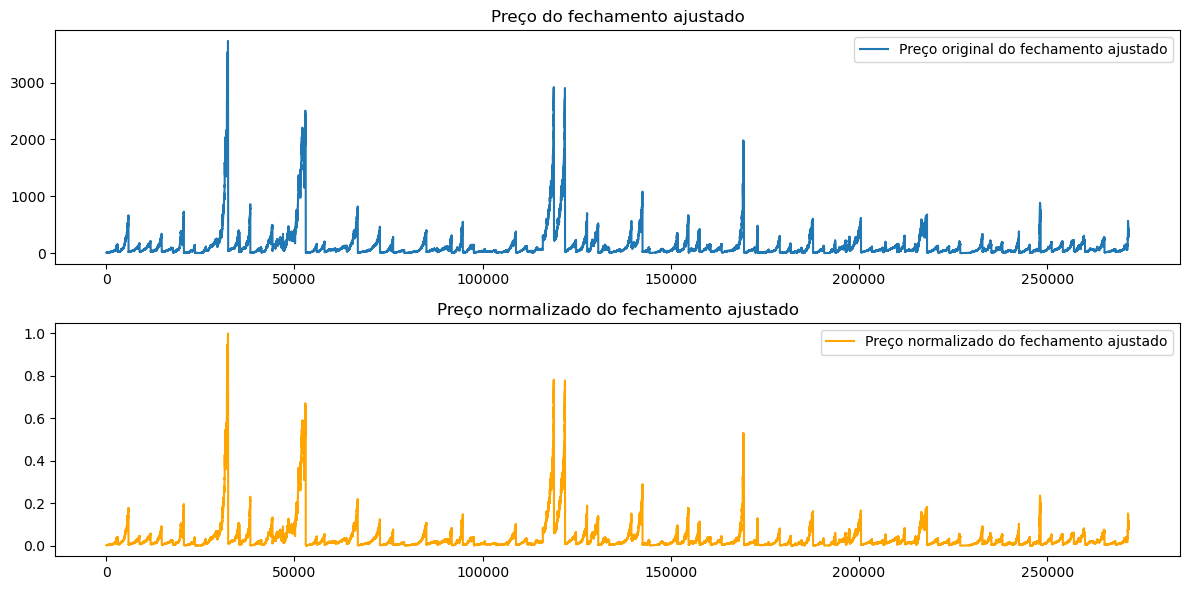

'\nReferências:\nhttps://matplotlib.org/stable/index.html\n\n'

In [124]:
#Gráfico com valores do Fechamento Ajustado e valores normalizados do Fechamento Ajustado

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(nasdaq_dados['Adj_Close'], label='Preço original do fechamento ajustado')
plt.title('Preço do fechamento ajustado')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nasdaq_scaled['Adj_Close_scaled'], label='Preço normalizado do fechamento ajustado', color='orange')
plt.title('Preço normalizado do fechamento ajustado')
plt.legend()

plt.tight_layout()
plt.show()


"""
Referências:
https://matplotlib.org/stable/index.html

"""

Matrizes de multicolinearidade

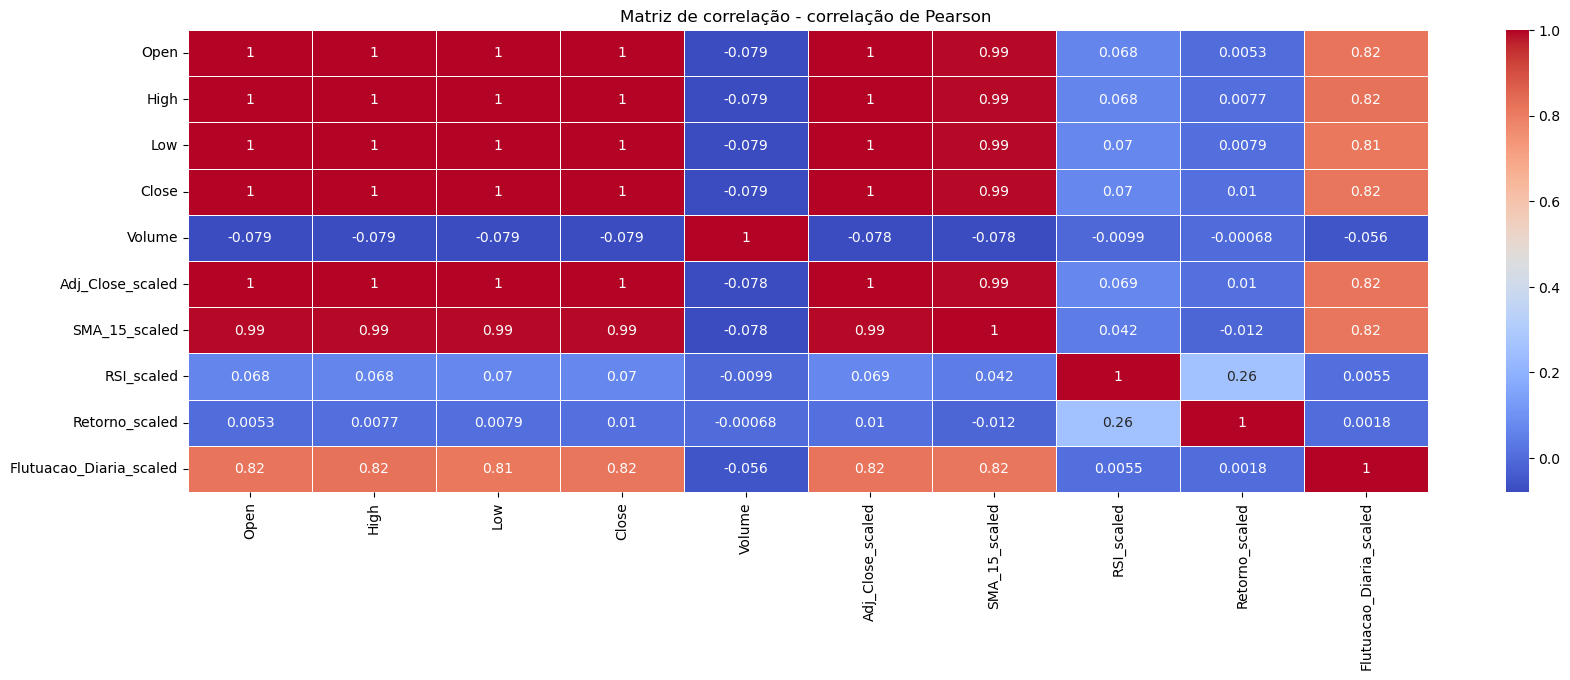

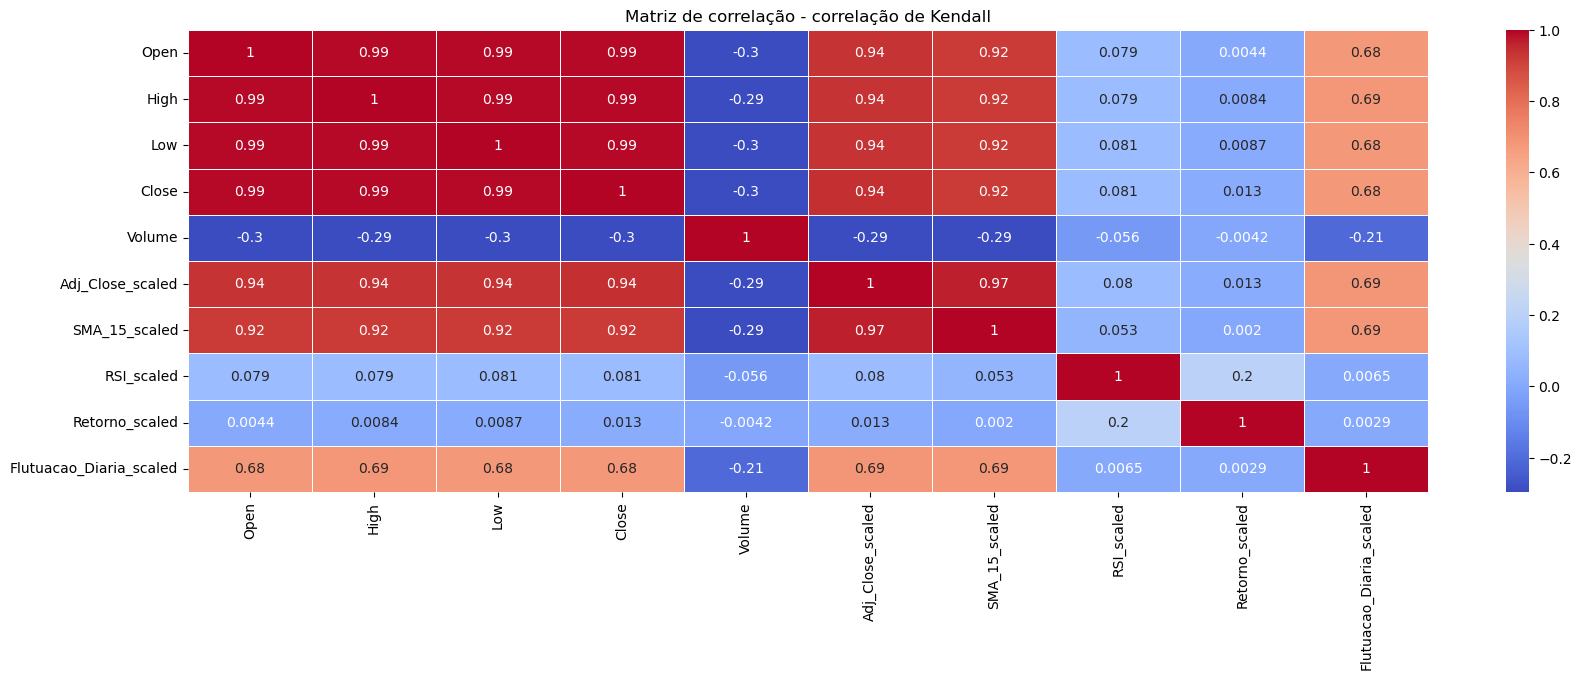

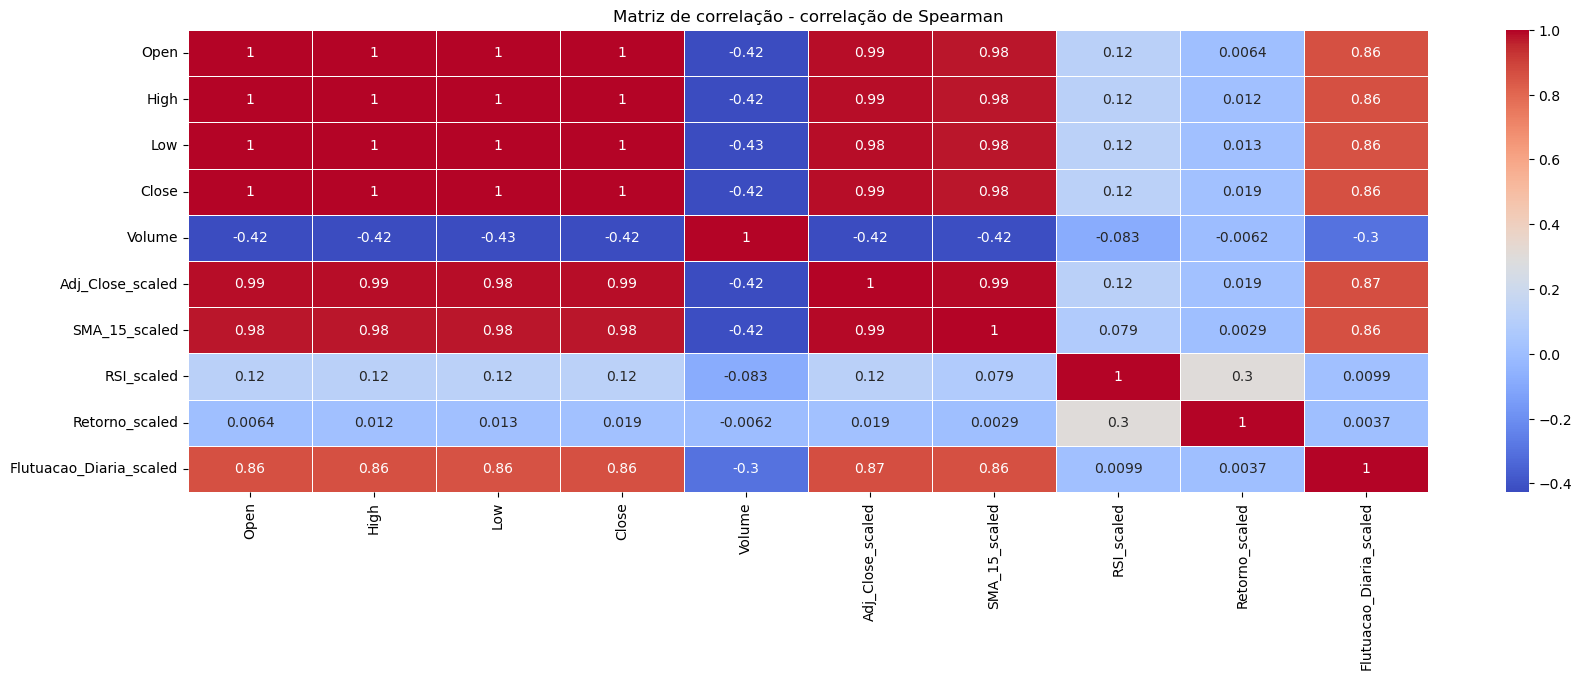

'\nReferências:\n\nhttps://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html\nhttps://seaborn.pydata.org/\nhttps://matplotlib.org/stable/index.html\n\n\n'

In [125]:
#Multicolinearidade

nasdaq_dados_correlacao = nasdaq_dados.drop(columns=['Date','Year','Name', 'Adj_Close', 'SMA_15', 'RSI', 'Retorno','Flutuacao_Diaria']).copy()

#Usando correlação de Pearson - Linear
pearson_matrix = nasdaq_dados_correlacao.corr()
plt.figure(figsize=(20, 6))
sns.heatmap(pearson_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlação - correlação de Pearson ')
plt.show()


#Usando correlação de Kendall

pearson_matrix = nasdaq_dados_correlacao.corr(method='kendall')
plt.figure(figsize=(20, 6))
sns.heatmap(pearson_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlação - correlação de Kendall')
plt.show()

#Usando correlação de Spearman

pearson_matrix = nasdaq_dados_correlacao.corr(method='spearman')
plt.figure(figsize=(20, 6))
sns.heatmap(pearson_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlação - correlação de Spearman')
plt.show()


"""
Referências:

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
https://seaborn.pydata.org/
https://matplotlib.org/stable/index.html


"""


Gráfico com as 10 empresas da Nasdaq que obtiveram o maior retorno acumulativo durante os 11 anos

Top 10 empresas pelo retorno acumulativo:
Name
SNPS    6.299841e+261
GOOG    6.275234e+261
NFLX    5.649399e+261
MELI    5.435671e+261
DXCM    5.204964e+261
NVDA    4.847980e+261
ALGN    4.805715e+261
AMZN    4.472339e+261
AVGO    4.403414e+261
REGN    4.317120e+261
dtype: float64


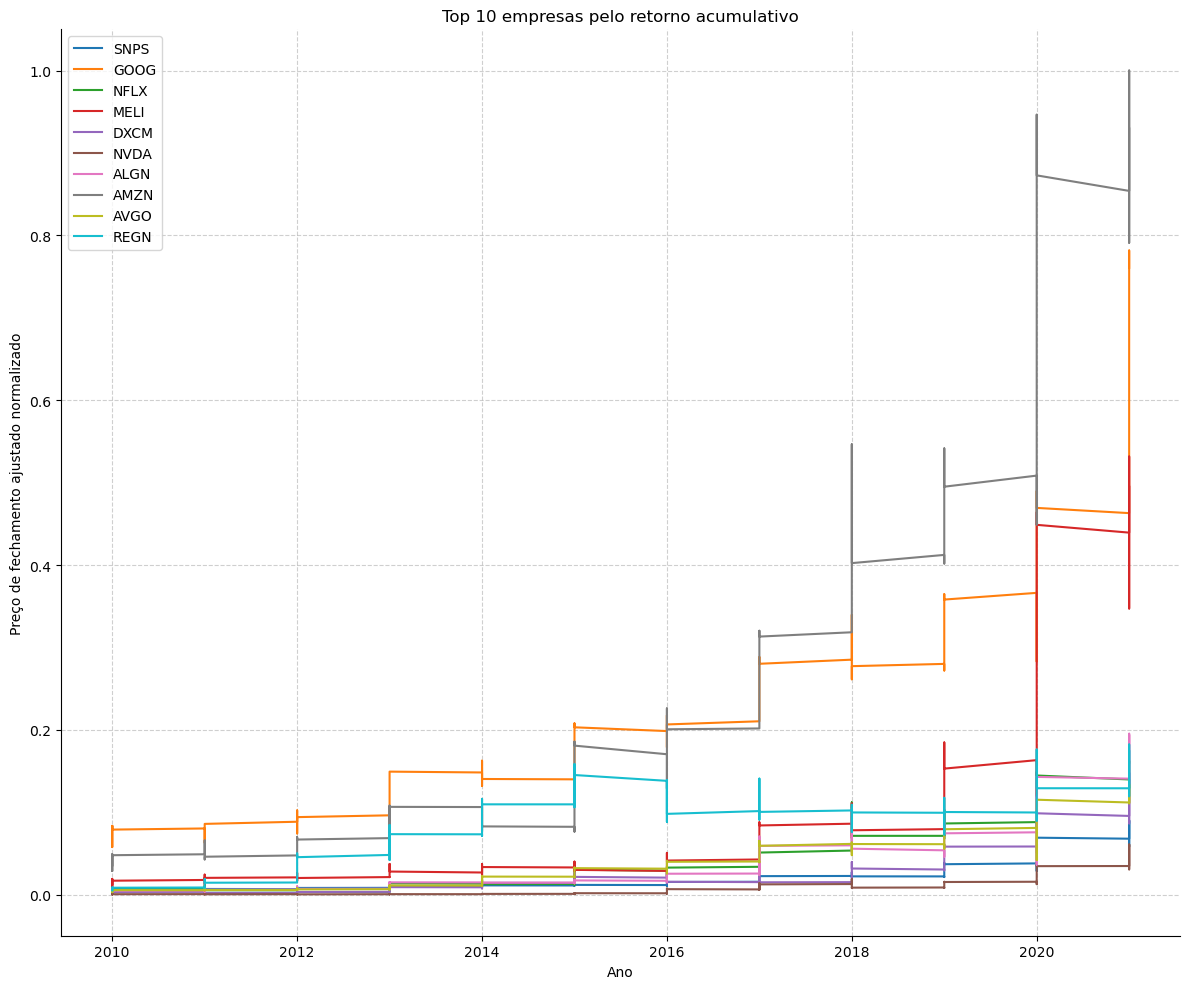

'\nReferências:\n\nhttps://pandas.pydata.org/docs\nhttps://matplotlib.org/stable/index.html\n\n\n'

In [126]:


def retorno_acumulativo(group):
    return np.prod(1 + group['Retorno_scaled']) - 1

retorno_acumulativo = nasdaq_dados.groupby('Name').apply(retorno_acumulativo,include_groups=False)


top10_empresas = retorno_acumulativo.sort_values(ascending=False).head(10).index.tolist()
print("Top 10 empresas pelo retorno acumulativo:")
print(retorno_acumulativo.sort_values(ascending=False).head(10))

# Dataframe filtrado
top5_data = nasdaq_dados[nasdaq_dados['Name'].isin(top10_empresas)]


plt.figure(figsize=(12, 10))
for empresa in top10_empresas:
    dados_empresa = top5_data[top5_data['Name'] == empresa]
    plt.plot(dados_empresa['Year'], dados_empresa['Adj_Close_scaled'], label=empresa)

plt.xlabel('Ano')
plt.ylabel('Preço de fechamento ajustado normalizado')
plt.title('Top 10 empresas pelo retorno acumulativo')

ax = plt.gca()
ax.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()



"""
Referências:

https://pandas.pydata.org/docs
https://matplotlib.org/stable/index.html


"""

Boxplot da distribuição das 10 empresas com a maior média da flutuação diária

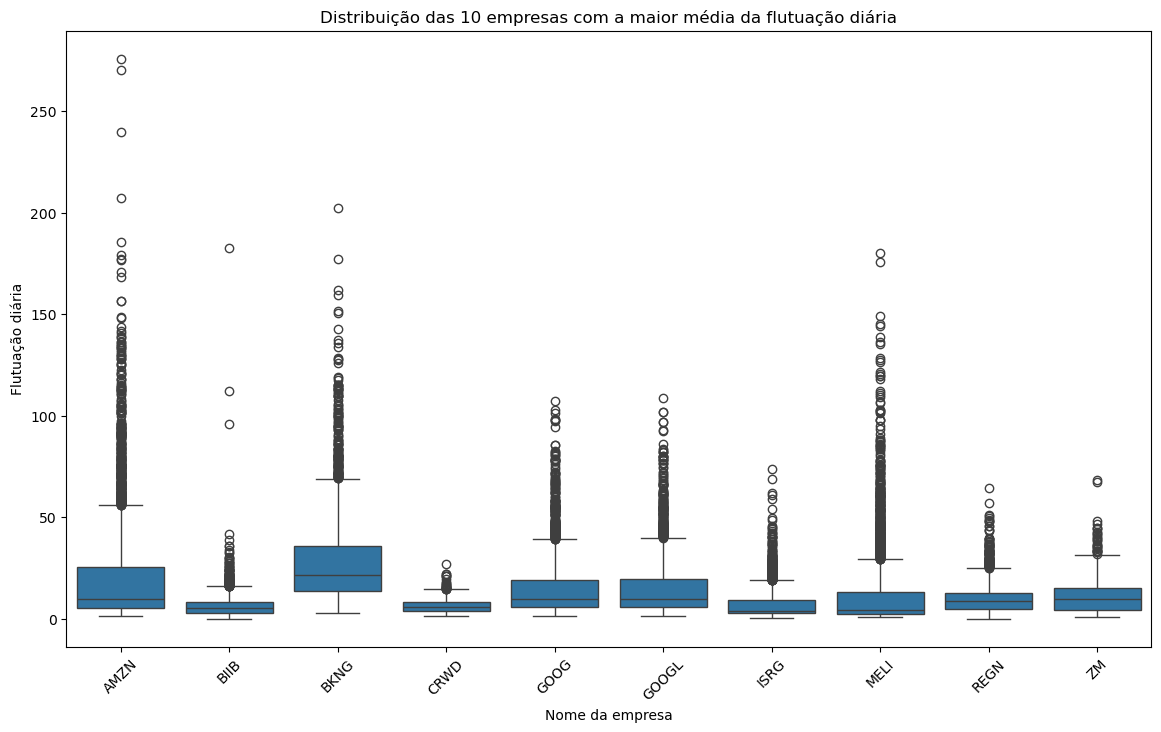

'\nReferências:\n\nhttps://pandas.pydata.org/docs\nhttps://matplotlib.org/stable/index.html\n\n\n'

In [127]:


avg_fluctuation = nasdaq_dados.groupby('Name')['Flutuacao_Diaria'].mean()
top10_companies = avg_fluctuation.nlargest(10).index
top10_data = nasdaq_dados[nasdaq_dados['Name'].isin(top10_companies)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='Name', y='Flutuacao_Diaria', data=top10_data)
plt.xlabel('Nome da empresa')
plt.ylabel('Flutuação diária')
plt.title('Distribuição das 10 empresas com a maior média da flutuação diária')
plt.xticks(rotation=45)
plt.show()



"""
Referências:

https://pandas.pydata.org/docs
https://matplotlib.org/stable/index.html


"""


Gráfico com a flutuação média diária das empresas pela média do volume diário das empresas

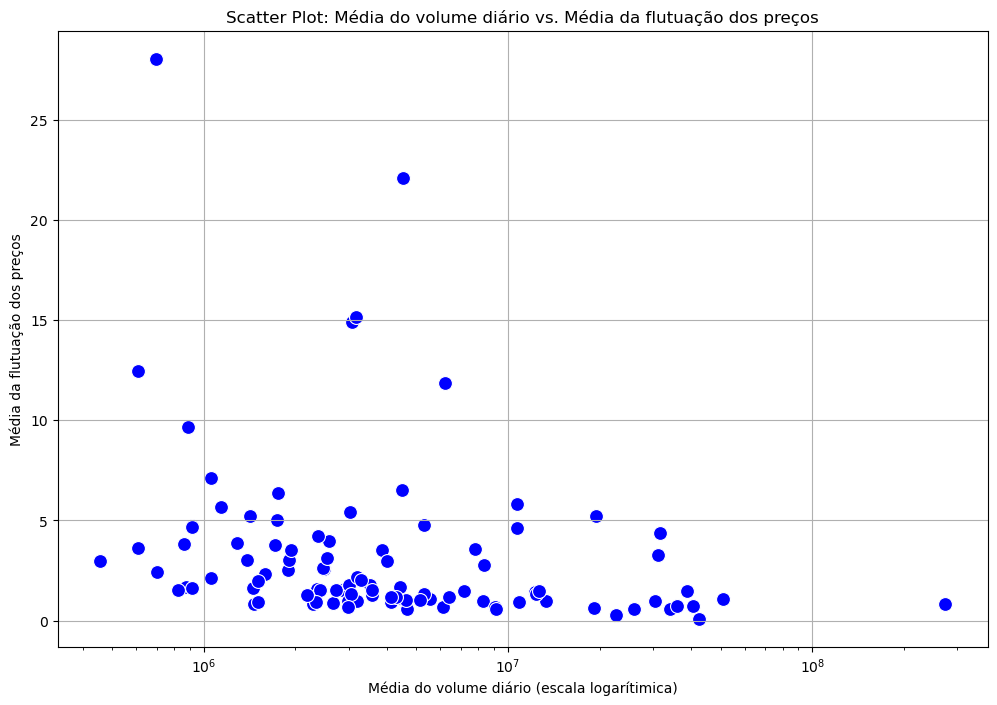

'\nReferências:\n\nhttps://pandas.pydata.org/docs\nhttps://matplotlib.org/stable/index.html\n\n'

In [128]:
media_df = nasdaq_dados.groupby('Name').agg({
    'Volume': 'mean',
    'Flutuacao_Diaria': 'mean'
}).reset_index()

plt.figure(figsize=(12, 8))
sns.scatterplot(data=media_df, x='Volume', y='Flutuacao_Diaria', s=100, color='blue', edgecolor='w')

plt.xscale('log')  # eixo x na escala logaritimica
plt.xlabel('Média do volume diário (escala logarítimica)')
plt.ylabel('Média da flutuação dos preços')
plt.title('Scatter Plot: Média do volume diário vs. Média da flutuação dos preços')
plt.grid(True)
plt.show()



"""
Referências:

https://pandas.pydata.org/docs
https://matplotlib.org/stable/index.html

"""

Número de empresas baseado na categoria de volume

/tmp/ipykernel_3282/1939936443.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Volume_bin', data=volume_media, order=["Low", "Medium-Low", "Medium-High", "High"], palette="Set2")


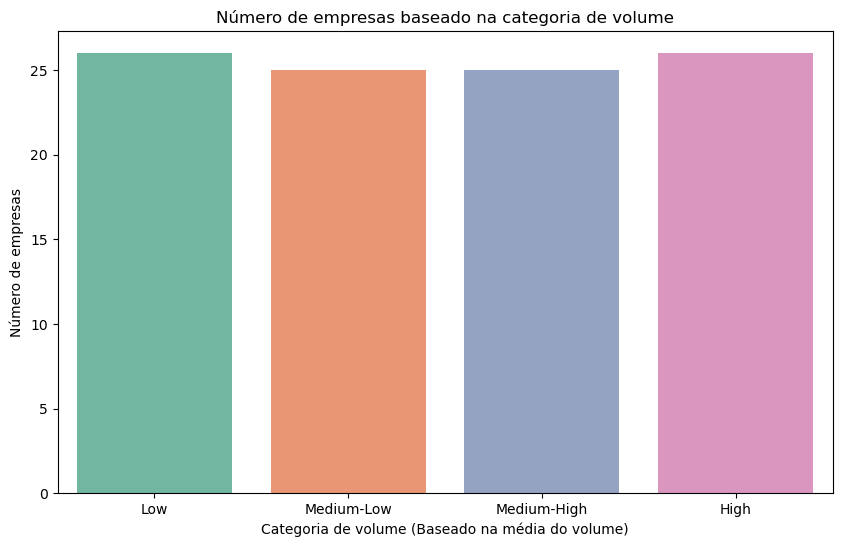

'\nReferências:\n\nhttps://pandas.pydata.org/docs\nhttps://matplotlib.org/stable/index.html\n\n\n'

In [129]:
volume_media = nasdaq_dados.groupby('Name')['Volume'].mean().reset_index()

volume_media['Volume_bin'], bin_edges = pd.qcut(
    volume_media['Volume'], 
    q=4, 
    retbins=True, 
    labels=["Low", "Medium-Low", "Medium-High", "High"]
)


plt.figure(figsize=(10, 6))
sns.countplot(x='Volume_bin', data=volume_media, order=["Low", "Medium-Low", "Medium-High", "High"], palette="Set2")
plt.xlabel("Categoria de volume (Baseado na média do volume)")
plt.ylabel("Número de empresas")
plt.title("Número de empresas baseado na categoria de volume")
plt.show()

"""
Referências:

https://pandas.pydata.org/docs
https://matplotlib.org/stable/index.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html


"""

Violinplot que mostra a distribuição de cada fechamento ajustado conforme 4 valores de intervalo de volumes

/tmp/ipykernel_3282/3695995551.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Categoria_Volume', y='Adj_Close', data=nasdaq_dados, inner="quartile", palette="Set2")


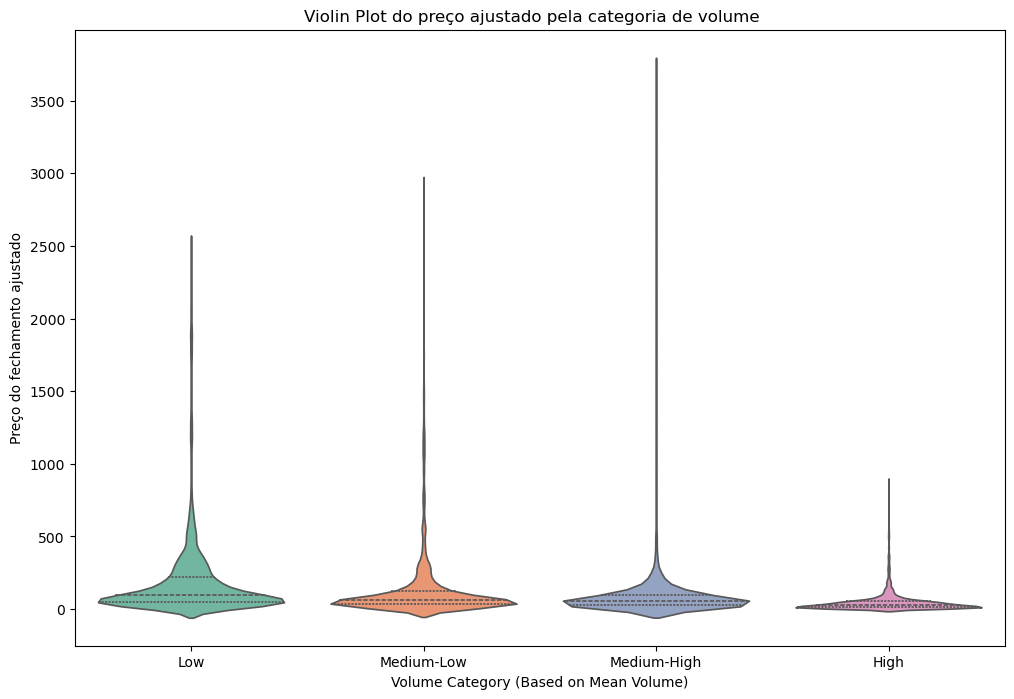

'\nReferências:\n\nhttps://pandas.pydata.org/docs\nhttps://matplotlib.org/stable/index.html\n\n'

In [130]:
media_volume = nasdaq_dados.groupby('Name')['Volume'].mean()

volume_bins = pd.qcut(media_volume, q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])
bin_edges = pd.qcut(nasdaq_dados['Volume'], q=4, labels=["Low", "Medium-Low", "Medium-High", "High"])

categorias_volume = pd.DataFrame({'Media_Volume': media_volume, 'Categoria_Volume': volume_bins })

nasdaq_dados = nasdaq_dados.merge(categorias_volume[['Categoria_Volume']], left_on='Name', right_index=True, how='left')

plt.figure(figsize=(12, 8))
sns.violinplot(x='Categoria_Volume', y='Adj_Close', data=nasdaq_dados, inner="quartile", palette="Set2")
plt.xlabel("Volume Category (Based on Mean Volume)")
plt.ylabel("Preço do fechamento ajustado")
plt.title("Violin Plot do preço ajustado pela categoria de volume   ")
plt.show()



"""
Referências:

https://pandas.pydata.org/docs
https://matplotlib.org/stable/index.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html

"""